In [19]:
import os
import glob
import math
import time
import igraph as ig
import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import entropy
from scipy.special import softmax
from collections import Counter
import matplotlib.pyplot as plt
from sympy.utilities.iterables import multiset_permutations


In [ ]:
from RenyiMI import *

In [ ]:
figure_folder = 'figures'
data_folder = 'data'
if not os.path.exists(figure_folder):
    os.mkdir(figure_folder)

## determine the best order $\alpha$ of the Rényi mutual information

In [48]:
def create_dataset(order=1, savefig=False, coeff=True):
    count = 0
    n1 = 5
    n2 = 4
    n = n1 + n2
    N = 1000
    samples = N * math.comb(n, n1)

    aas = np.empty(samples, dtype=float)
    dIs = np.empty(samples, dtype=float)
    das = np.empty(samples, dtype=float)
    I1s = np.empty(samples, dtype=float)
    I2s = np.empty(samples, dtype=float)

    block_sizes = [n1, n2]

    for i in range(N):
        pref_matrix = np.random.rand() * 0.3 + 0.7
        pref_matrix = [[round(pref_matrix, 1), 0.2], [0.2, round(pref_matrix, 1)]]
        g = ig.Graph.SBM(n, pref_matrix, block_sizes)

        node_labels = [1] * n1 + [0] * n2
        if g.is_connected():

            for labels in multiset_permutations(node_labels):
                delta_I, I2, I1, a1, a2 = metrics(g, labels, order=order)
                aas[count] = a2
                dIs[count] = delta_I
                I2s[count] = I2
                I1s[count] = I1
                das[count] = a1
                count += 1

    aas = aas[:count]
    dIs = dIs[:count]
    I2s = I2s[:count]
    das = das[:count]
    I1s = I1s[:count]
    dI_coeff = plot_measure_correlation(aas, das, dIs, name="Mutual Information", order=order, savefig=savefig, coeff=coeff)
    
    return dI_coeff

creating Renyi-0.1 mutual information
creating Renyi-0.2 mutual information
creating Renyi-0.3 mutual information
creating Renyi-0.4 mutual information
creating Renyi-0.5 mutual information
creating Renyi-0.6 mutual information
creating Renyi-0.7 mutual information
creating Renyi-0.8 mutual information
creating Renyi-0.9 mutual information
creating Renyi-1.0 mutual information
creating Renyi-1.1 mutual information
creating Renyi-1.2 mutual information
creating Renyi-1.3 mutual information
creating Renyi-1.4 mutual information
creating Renyi-1.5 mutual information
creating Renyi-1.6 mutual information
creating Renyi-1.7 mutual information
creating Renyi-1.8 mutual information
creating Renyi-1.9 mutual information
creating Renyi-2.0 mutual information
creating Renyi-2.1 mutual information


C:\Users\Owner\AppData\Local\Temp\ipykernel_17968\664785225.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2, 2, figsize=(6, 6))


creating Renyi-2.2 mutual information
creating Renyi-2.3 mutual information
creating Renyi-2.4 mutual information
creating Renyi-2.5 mutual information
creating Renyi-2.6 mutual information
creating Renyi-2.7 mutual information
creating Renyi-2.8 mutual information
creating Renyi-2.9 mutual information
creating Renyi-3.0 mutual information


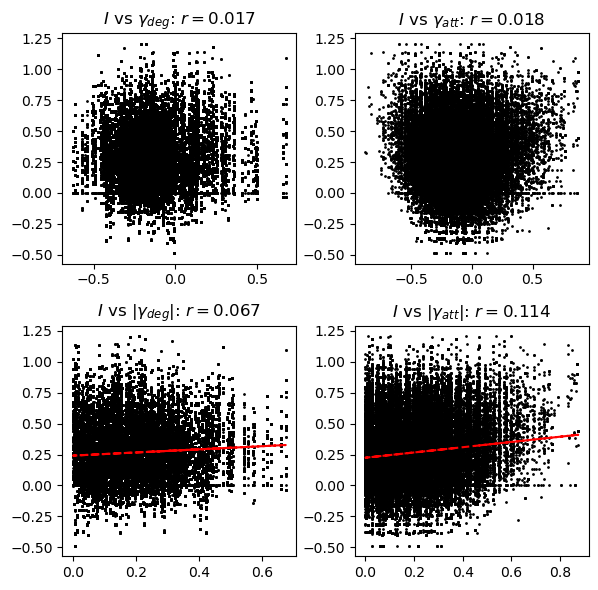

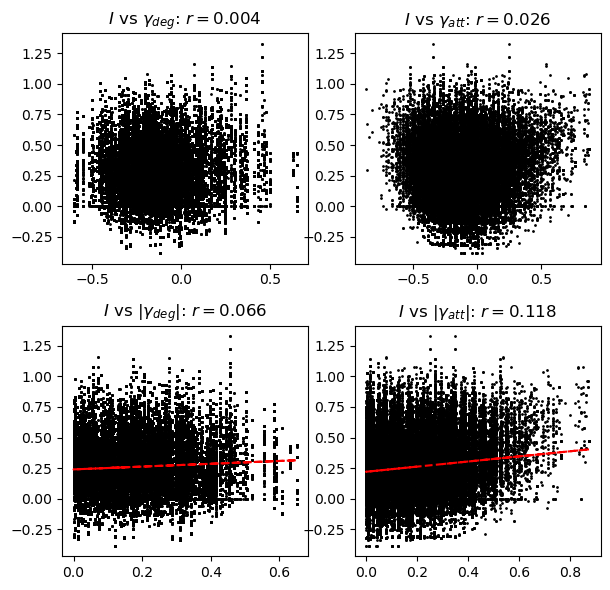

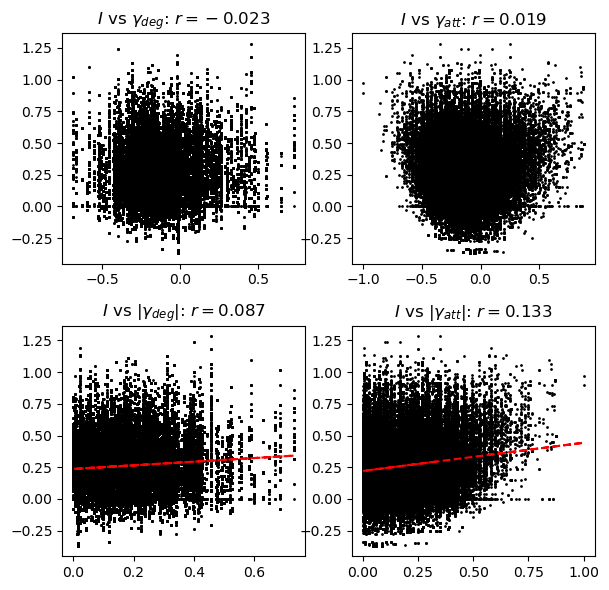

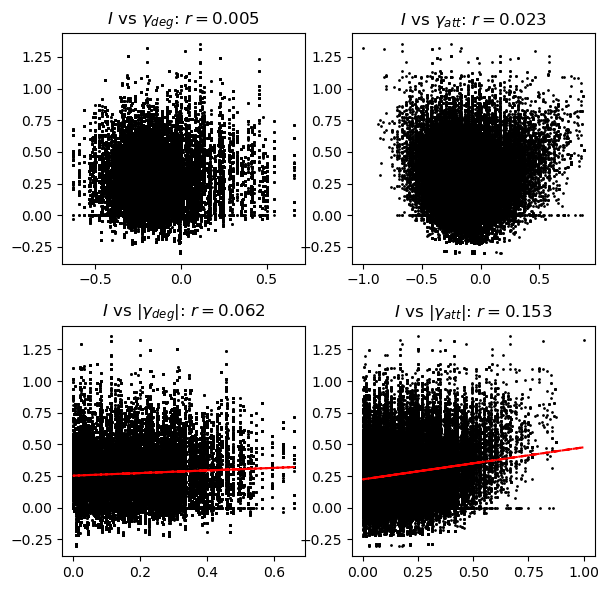

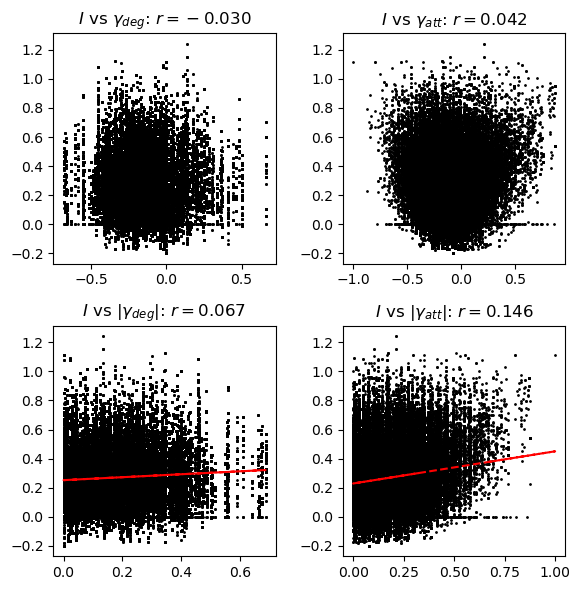

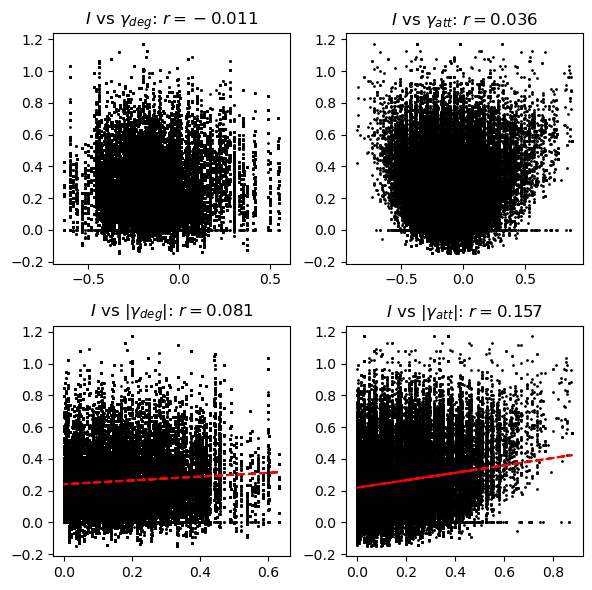

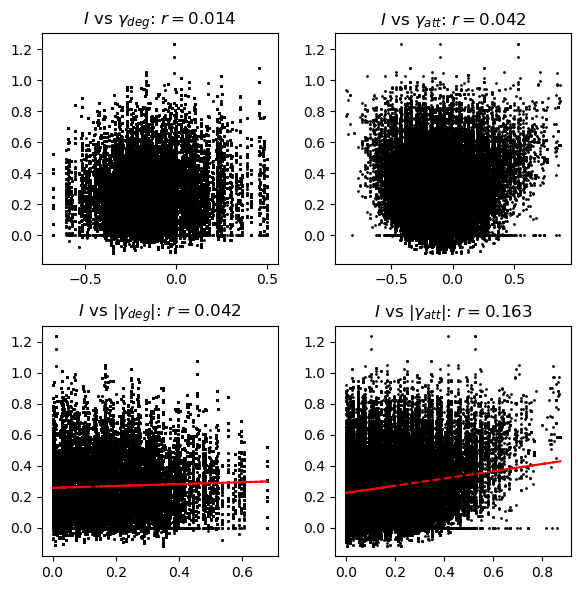

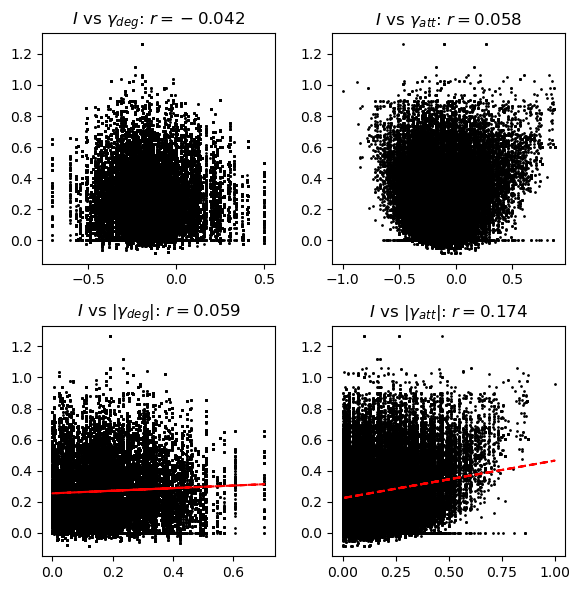

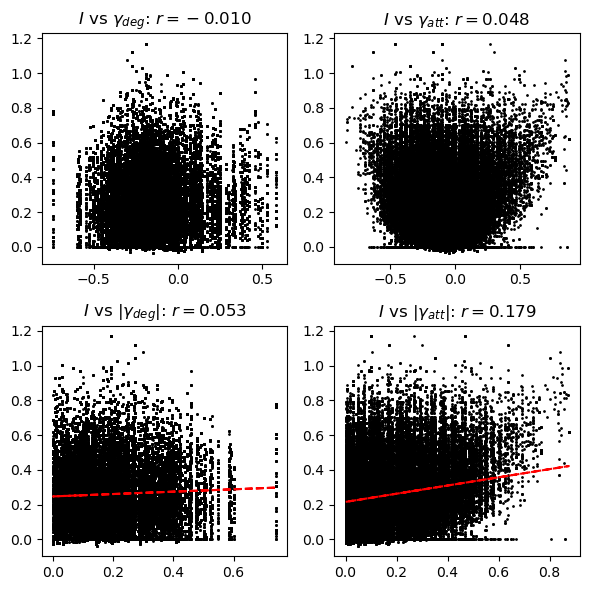

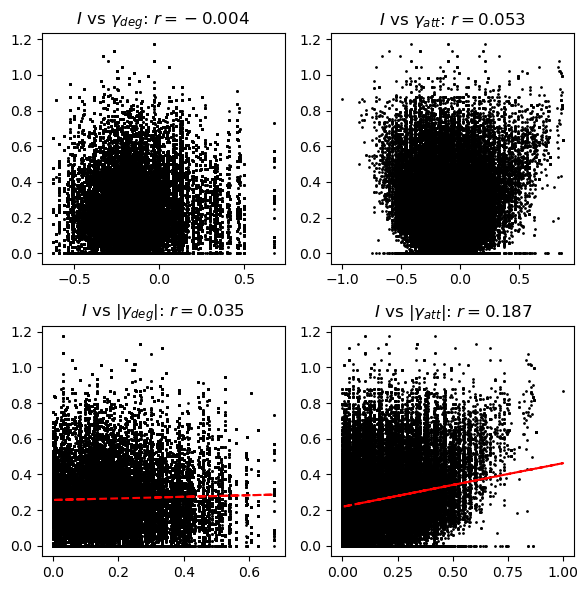

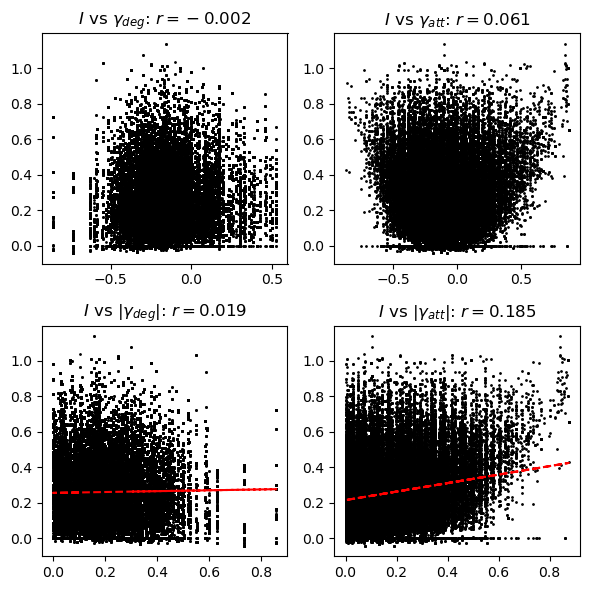

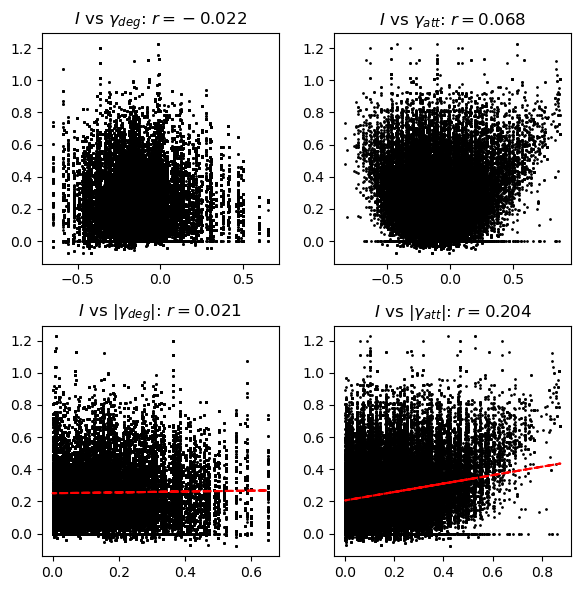

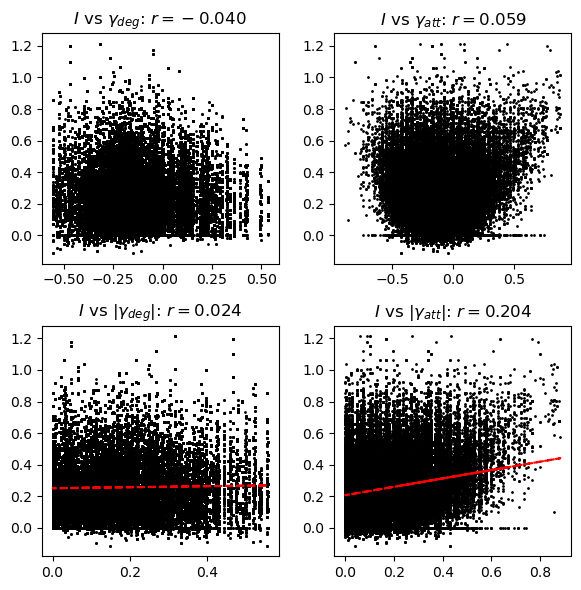

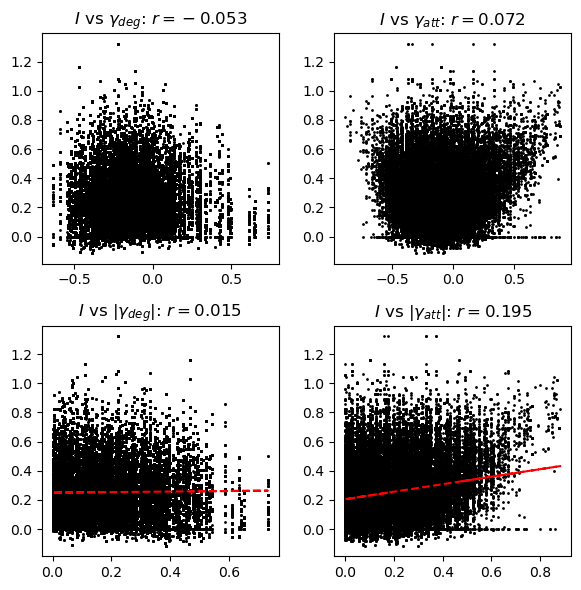

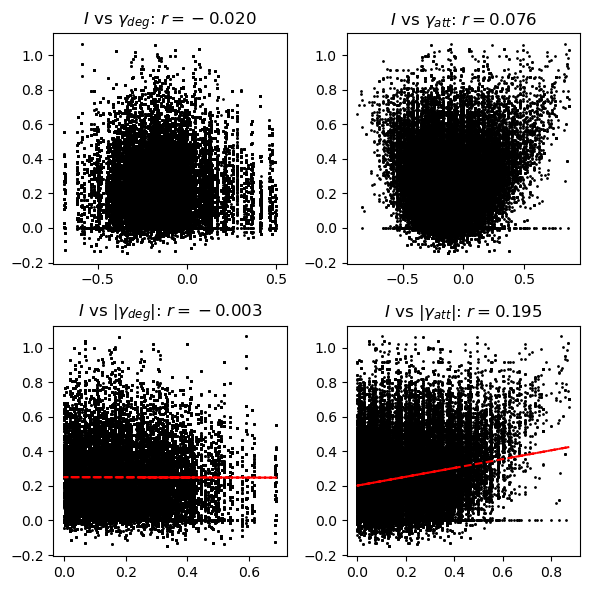

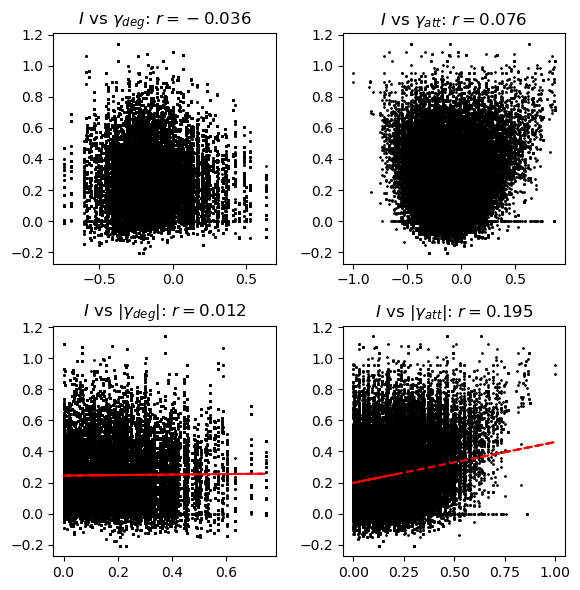

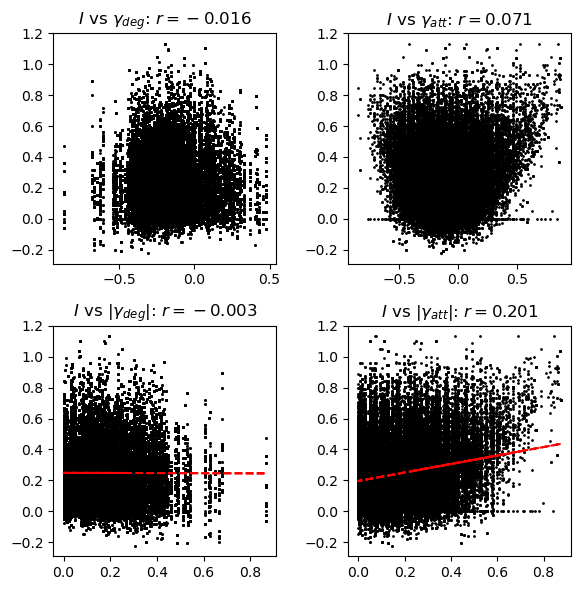

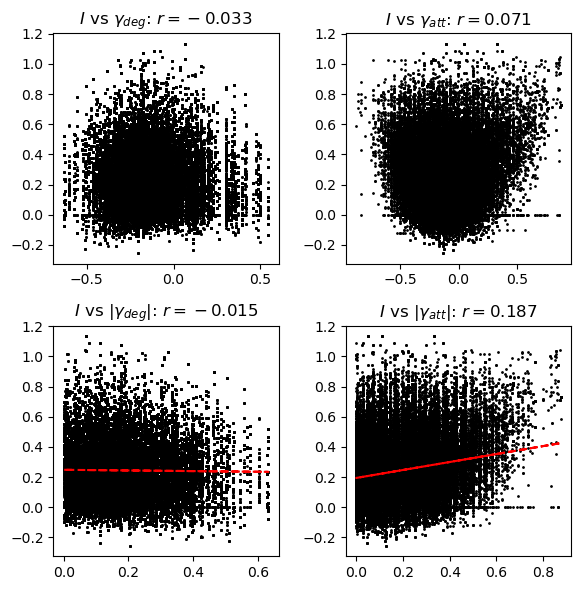

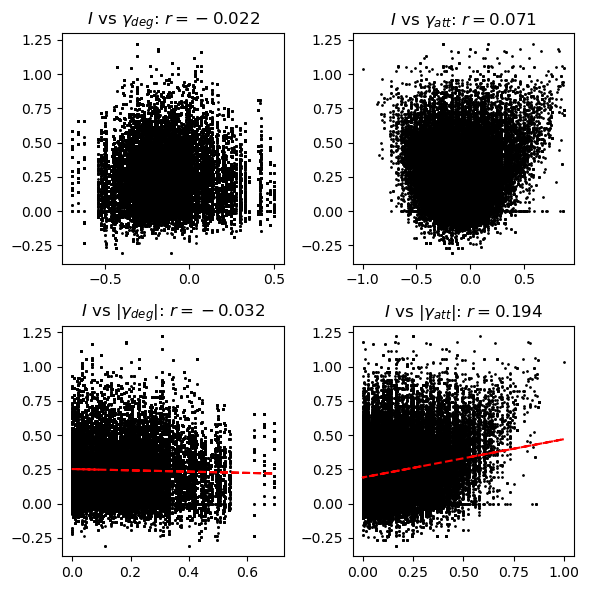

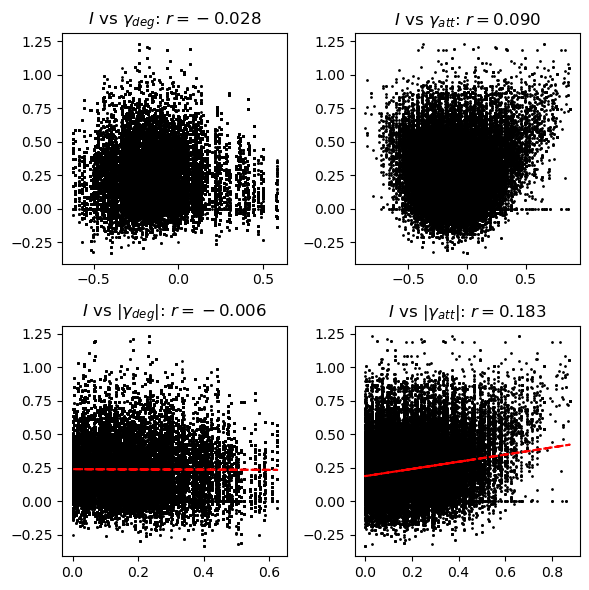

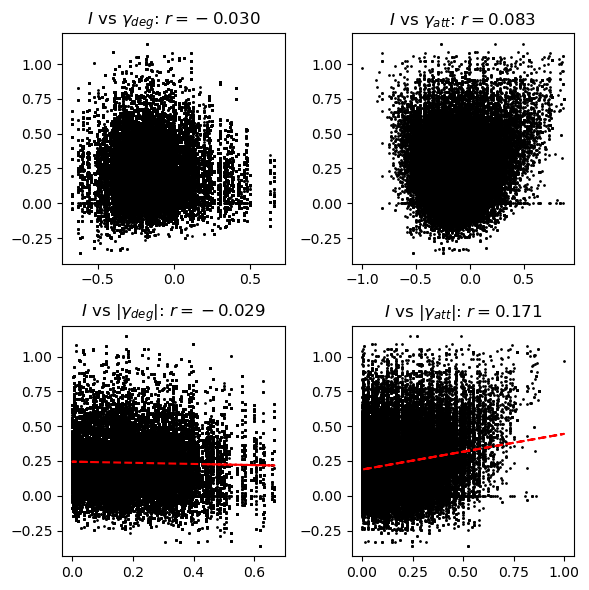

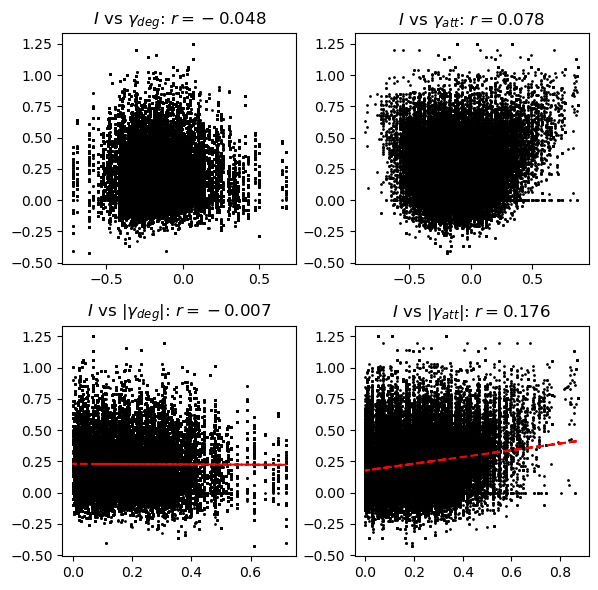

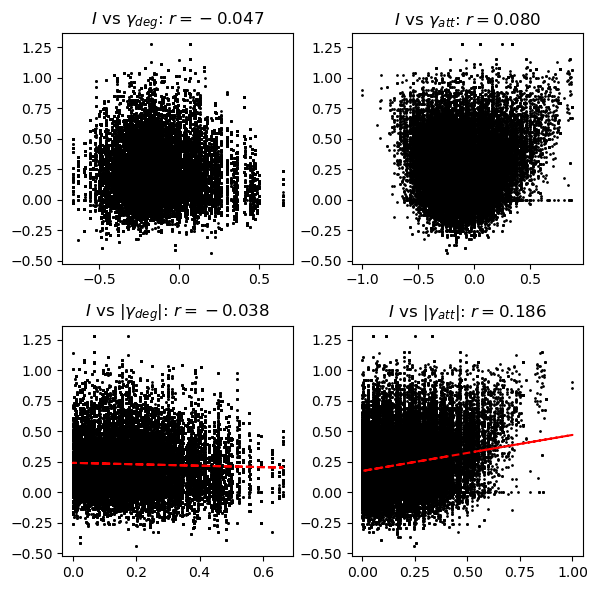

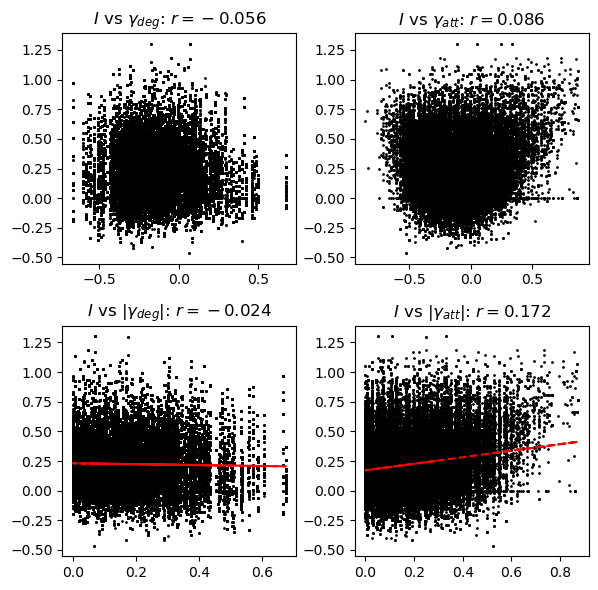

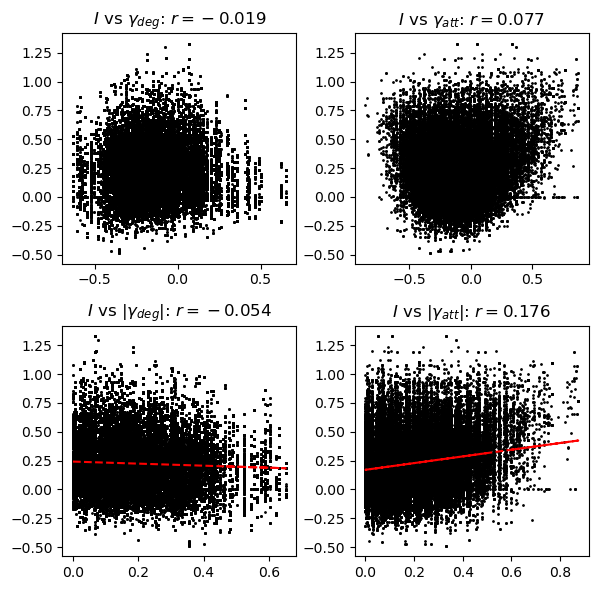

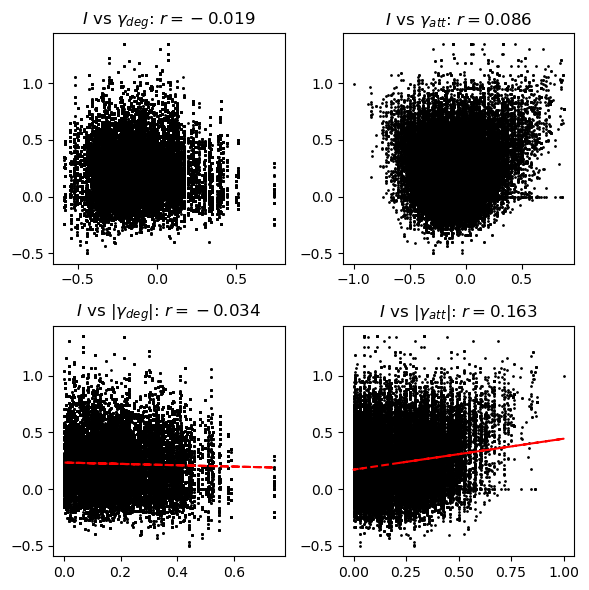

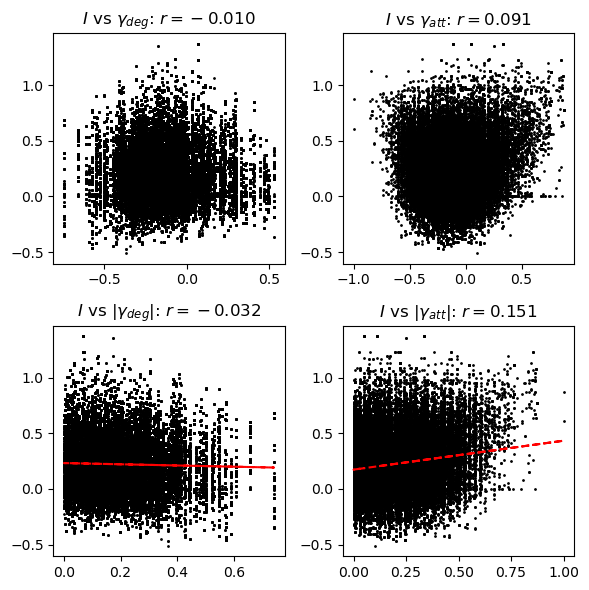

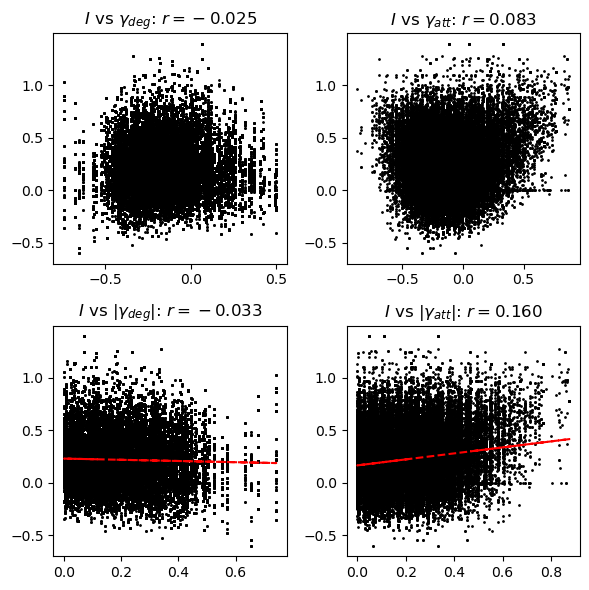

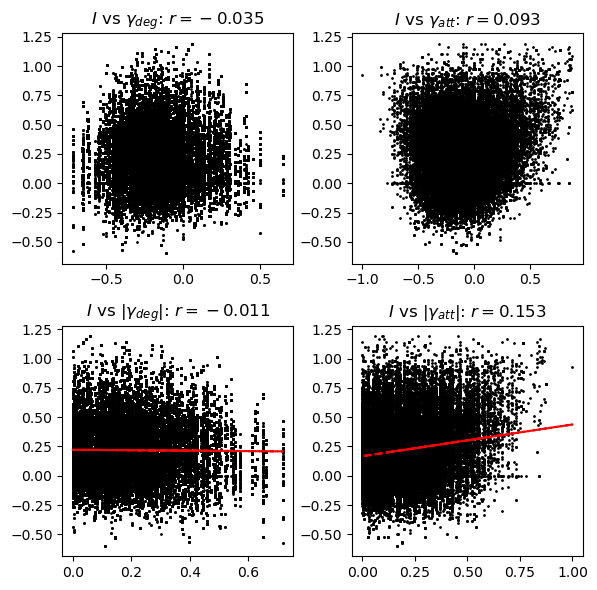

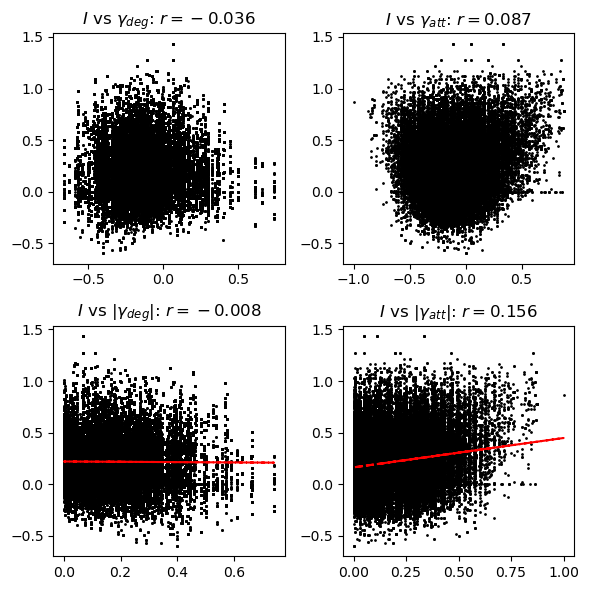

In [72]:
Renyi_order_result = pd.DataFrame(columns=["alpha", "linear_coeff"])
for i, alpha in enumerate(np.around(np.linspace(0.1, 3, 30), decimals=1)): #[0.1, 0.5, 1, 2, np.inf]:
    print(f"creating Renyi-{alpha} mutual information")
    linear_coeff = create_dataset(order=alpha, savefig=False, coeff=True)
    Renyi_order_result.loc[i] = [alpha, linear_coeff]

Text(0, 0.5, '$r$')

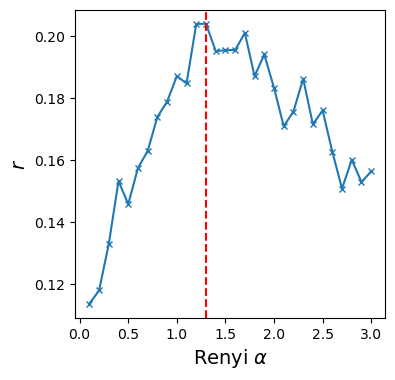

In [81]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(Renyi_order_result["alpha"].values, Renyi_order_result["linear_coeff"].values, marker='x', markersize=4)
ax.axvline(x=Renyi_order_result['alpha'].iloc[Renyi_order_result['linear_coeff'].argmax()], linestyle='--', color='r')
ax.set_xlabel('Renyi ' + r"$\alpha$", fontsize=14)
ax.set_ylabel(r"$r$", fontsize=14) #'Correlation Coefficient between ' + r"$I$" + " and " + r"$|\gamma_{att}|$"
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "r_vs_alpha.png"), dpi=100)

## plot the Rényi mutual information of the citation network datasets

In [ ]:
alpha = 1.3 # Renyi-alpha

In [ ]:
for fname in glob.glob(os.path.join(data_folder, "*.csv")):
    subject = fname.split('\\')[-1].split('_')[0]
    if "economics" in subject:
        continue # file too large
    if "aps" in subject:
        citation = pd.read_csv(fname)
    else:
        citation = pd.read_csv(fname, index_col=[0])
    
    # remove NAN entries and other meaningless entries; keep only year 2003 - 2012
    citation_valid = citation[(citation['to_author_gender']!='not_in_db') & (citation['from_author_gender']!='not_in_db') &
                              (citation['to_author_gender']!='unknown') & (citation['from_author_gender']!='unknown') &
                              (citation['to_author_gender']!='andy') & (citation['from_author_gender']!='andy')]
    citation_valid = citation_valid[~citation_valid['year'].isnull()]
    citation_valid = citation_valid[(citation_valid['year'] > 2002) & (citation_valid['year'] < 2019)]
    
    # compute the rational attention for the dataset
    results = pd.DataFrame(columns=['year', 'RA(t=T)', 'I1', 'I2'])
    row_id = 0
    for year in range(2003, 2019):
        citation_per_year = citation_valid[citation_valid['year']==year]
        edge_list = citation_per_year[['from_author', 'to_author']].loc[citation_per_year.index.repeat(citation_per_year.times)].values
        print(f"---- year {year}: {len(edge_list)} edges ----")
        G = nx.from_edgelist(edge_list)
        adj = nx.to_scipy_sparse_array(G) # nx.to_numpy_array(G)
        print(f"shape of the adjacency matrix: {adj.shape}")
        ordering = list(G.nodes())

        dict1 = pd.Series(citation_per_year['from_author_gender'].values, index=citation_per_year['from_author'].values).to_dict()
        dict2 = pd.Series(citation_per_year['to_author_gender'].values, index=citation_per_year['to_author'].values).to_dict()
        dict_gender = {**dict1, **dict2}
        dict_gender = {id: 0 if gender=='male' or gender=='mostly_male' else 1 for id, gender in dict_gender.items()}
        labels = [dict_gender[author] for author in ordering]
        
        tic = time.time()
        RAt, I2, I1 = MI_JDAM(construct_full_JDAM_from_adj(adj, labels), order=alpha)
        print(f"Rational attention: {RAt}; computation time: {time.time() - tic} s")
        results.at[row_id] = [year, RAt, I1, I2]
        row_id += 1
        
    results.to_csv(os.path.join(data_folder, fname.split(".csv")[0] + "_rational_attention.csv"))

In [ ]:
fontsize = 16
markersize = 10
fig, ax = plt.subplots(figsize=(8, 6))
colors = get_standard_colors(len(glob.glob(os.path.join(folder + "/" + "*rational_attention.csv"))))
markers = ["o", "v", "^", "<", ">", "s", "p", "*"]

for i, fname in enumerate(glob.glob(os.path.join(data_folder + "/" + "*rational_attention.csv"))):
    subject = fname.split('\\')[-1].split('_')[0]
    result = pd.read_csv(fname, index_col=[0])
    ax.plot(result['year'].values, result['RA(t=T)'].values, marker=markers[i], color=colors[i], markersize=markersize, label=subject)

fig.legend(bbox_to_anchor=(0, 1.0, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4, fontsize=fontsize)
ax.set_xticks(np.arange(2003,2019, dtype=int))
ax.set_xticklabels(np.arange(2003,2019, dtype=int), rotation=60)
ax.set_xlabel('Year', fontsize=fontsize) # ax.xaxis.label.set_size(14)
ax.set_ylabel(r'Mutual Information Metric $I_{\alpha}$', fontsize=fontsize)
plt.tight_layout()
fig.savefig(figure_folder + '/' + 'MI_increase_by_year_citation_per_subject_2018.png', bbox_inches="tight", dpi=100)


## SPSA stochastic optimization over the edge sampling distributions

### get the citation network for physics in 2012

In [3]:
fname = glob.glob(os.path.join("aps*.csv"))[0]
citation = pd.read_csv(fname)
citation_valid = citation[(citation['to_author_gender']!='not_in_db') & (citation['from_author_gender']!='not_in_db') &
                          (citation['to_author_gender']!='unknown') & (citation['from_author_gender']!='unknown') &
                          (citation['to_author_gender']!='andy') & (citation['from_author_gender']!='andy')]
citation_valid = citation_valid[~citation_valid['year'].isnull()]
citation_valid = citation_valid[(citation_valid['year'] > 2002) & (citation_valid['year'] < 2013)]

year = 2012
citation_per_year = citation_valid[citation_valid['year']==year]
edge_list = citation_per_year[['from_author', 'to_author']].loc[citation_per_year.index.repeat(citation_per_year.times)].values
print(f"---- year {year}: {len(edge_list)} edges ----")
G = nx.from_edgelist(edge_list)
adj = nx.to_scipy_sparse_array(G) # nx.to_numpy_array(G)
print(f"shape of the adjacency matrix: {adj.shape}")
ordering = list(G.nodes())

dict1 = pd.Series(citation_per_year['from_author_gender'].values, index=citation_per_year['from_author'].values).to_dict()
dict2 = pd.Series(citation_per_year['to_author_gender'].values, index=citation_per_year['to_author'].values).to_dict()
dict_gender = {**dict1, **dict2}
dict_gender = {id: 0 if gender=='male' or gender=='mostly_male' else 1 for id, gender in dict_gender.items()}
labels = [dict_gender[author] for author in ordering]

# RAt, I2, I1 = MI_JDAM(adj, labels)

---- year 2012: 1115272 edges ----
shape of the adjacency matrix: (56919, 56919)


In [6]:
labels = np.array(labels, dtype=bool)
comat_full = construct_full_JDAM_from_adj(adj, labels)
print(comat_full.shape)

In [56]:
theta = np.random.randn(comat_full.shape[0]**2)
comat_full_copy = comat_full.copy()
Y, _, _ = MI_JDAM(comat_full_copy, order=alpha)
theta, loss_history = SPSA(LossFunction = lambda parameters: Loss(parameters, Y, order=alpha),
                           parameters = theta)

-------- iteration 1: loss 7.205473906424231e-06; parameter [-0.7256931   0.20618359  1.32770117  1.17896488 -0.54107619] ----------
-------- iteration 6: loss 4.1987495364992355e-06; parameter [ -31.2434632    62.5875142   -19.81748301   34.34215375 -102.75182936] ----------
-------- iteration 11: loss 1.1738286076479199e-05; parameter [ -25.9362405    67.29752406 -118.78318108   85.32181333  -36.827688  ] ----------
-------- iteration 16: loss 1.3622542184066333e-05; parameter [   1.6129062    61.8586721   -29.95303297  189.38193255 -125.65783611] ----------
-------- iteration 21: loss 5.230263639077748e-06; parameter [ -10.06851696    5.63970798   -5.9858003   209.95224084 -106.33689078] ----------
-------- iteration 26: loss -2.0289046176458214e-07; parameter [-20.77924844   7.53198007   2.20722797 213.10040708 -98.14386252] ----------
-------- iteration 31: loss -2.0289046176458214e-07; parameter [ -22.67240791    9.42513954    0.3140685   217.49950412 -102.54295955] ----------
--

-------- iteration 286: loss -3.9919757455209037e-07; parameter [ -23.58757587   13.1838037   -16.68266262  223.93097841 -118.10121401] ----------
-------- iteration 291: loss -3.9919757455209037e-07; parameter [ -21.95970376   13.1835853   -18.31053474  223.9319552  -117.10746039] ----------
-------- iteration 296: loss -6.665852936293959e-08; parameter [ -22.7688571    12.37443196  -16.51493002  223.75465311 -116.29830705] ----------
-------- iteration 301: loss 1.362317902930954e-07; parameter [ -22.28004059   11.88561545  -14.41880147  223.2658366  -114.2021785 ] ----------
-------- iteration 306: loss 1.362317902930954e-07; parameter [ -21.48104985   12.68460619  -13.61981073  222.46684586 -115.00116924] ----------
-------- iteration 311: loss 1.362317902930954e-07; parameter [ -21.48104985   12.68460619  -13.61981073  222.46684586 -115.00116924] ----------
-------- iteration 316: loss 1.362317902930954e-07; parameter [ -21.96243839   13.16599473  -14.10119927  221.98545732 -115.4

-------- iteration 571: loss -3.9919757455209037e-07; parameter [ -19.16590677   21.27491693  -17.0795331   217.73078179 -117.52343783] ----------
-------- iteration 576: loss -3.9919757455209037e-07; parameter [ -19.16590677   21.27491693  -17.0795331   217.73078179 -117.52343783] ----------
-------- iteration 581: loss -3.9919757455209037e-07; parameter [ -19.79016904   21.8991792   -16.45527084  218.35504405 -118.1477001 ] ----------
-------- iteration 586: loss -3.9919757455209037e-07; parameter [ -18.54519011   23.14415812  -15.21029191  219.60002298 -119.39267903] ----------
-------- iteration 591: loss -3.9919757455209037e-07; parameter [ -17.92445946   22.52342747  -14.58956126  220.22075363 -118.77194837] ----------
-------- iteration 596: loss -3.9919757455209037e-07; parameter [ -17.30763156   21.90659957  -15.20638916  219.60392573 -118.15512047] ----------
-------- iteration 601: loss -3.9919757455209037e-07; parameter [ -17.92282773   22.01915832  -15.31894791  220.945866

-------- iteration 851: loss -1.9630759595656855e-07; parameter [ -26.8370841    21.50765977  -14.79756608  218.47696463 -120.00914036] ----------
-------- iteration 856: loss -1.9630759595656855e-07; parameter [ -27.16047934   21.83072446  -15.12063077  218.80002831 -119.68607567] ----------
-------- iteration 861: loss -1.9630759595656855e-07; parameter [ -27.16047934   21.83072446  -15.12063077  218.80002831 -119.68607567] ----------
-------- iteration 866: loss -1.9630759595656855e-07; parameter [ -27.48189456   22.15213968  -14.79921555  218.47861309 -119.36466045] ----------
-------- iteration 871: loss -3.9919757455209037e-07; parameter [ -27.16178055   22.47225369  -15.11932956  218.7987271  -119.68477446] ----------
-------- iteration 876: loss -1.9630759595656855e-07; parameter [ -27.48157171   22.15246253  -14.7995384   218.47893593 -119.3649833 ] ----------
-------- iteration 881: loss -3.9919757455209037e-07; parameter [ -26.84375501   22.79027923  -14.79969825  217.841119

In [64]:
length = int(np.sqrt(len(theta)))
Y_old, _, _ = MI_JDAM(comat_full, order=alpha)
deg_old = degree_assortativity(comat_full)
att_old = attribute_assortativity(comat_full)
results_softmax = pd.DataFrame(columns=['num_edges', 'delta_I', 'delta_att', 'delta_deg'])
results_uniform = pd.DataFrame(columns=['num_edges', 'delta_I', 'delta_att', 'delta_deg'])

for i, num_edges in enumerate(np.logspace(3, 5, 20, dtype=int)):
    print(f"----- {i}: adding {num_edges} edges to the original network -------")
    addendum = np.random.choice(length**2, size=num_edges, p=softmax(theta))
    row, col = np.unravel_index(addendum, (length, length))
    comat_new = comat_full.copy()
    comat_new[row, col] += 1
    comat_new[col, row] += 1
    Y_new, _, _ = MI_JDAM(comat_new, order=alpha)
    deg_new = degree_assortativity(comat_new)
    att_new = attribute_assortativity(comat_new)
    results_softmax.loc[i] = [num_edges, (Y_new - Y) / np.abs(Y), (att_new - att_old) / np.abs(att_old), (deg_new - deg_old) / np.abs(deg_old)]
    
    addendum = np.random.choice(length**2, size=num_edges)
    row, col = np.unravel_index(addendum, (length, length))
    comat_new = comat_full.copy()
    comat_new[row, col] += 1
    comat_new[col, row] += 1
    Y_new = MI_JDAM(comat_new)
    deg_new = degree_assortativity(comat_new)
    att_new = attribute_assortativity(comat_new)    
    
    results_uniform.loc[i] = [num_edges, (Y_new - Y) / np.abs(Y), (att_new - att_old) / np.abs(att_old), (deg_new - deg_old) / np.abs(deg_old)]

----- 0: adding 1000 edges to the original network -------
----- 1: adding 1274 edges to the original network -------
----- 2: adding 1623 edges to the original network -------
----- 3: adding 2069 edges to the original network -------
----- 4: adding 2636 edges to the original network -------
----- 5: adding 3359 edges to the original network -------
----- 6: adding 4281 edges to the original network -------
----- 7: adding 5455 edges to the original network -------
----- 8: adding 6951 edges to the original network -------
----- 9: adding 8858 edges to the original network -------
----- 10: adding 11288 edges to the original network -------
----- 11: adding 14384 edges to the original network -------
----- 12: adding 18329 edges to the original network -------
----- 13: adding 23357 edges to the original network -------
----- 14: adding 29763 edges to the original network -------
----- 15: adding 37926 edges to the original network -------
----- 16: adding 48329 edges to the original

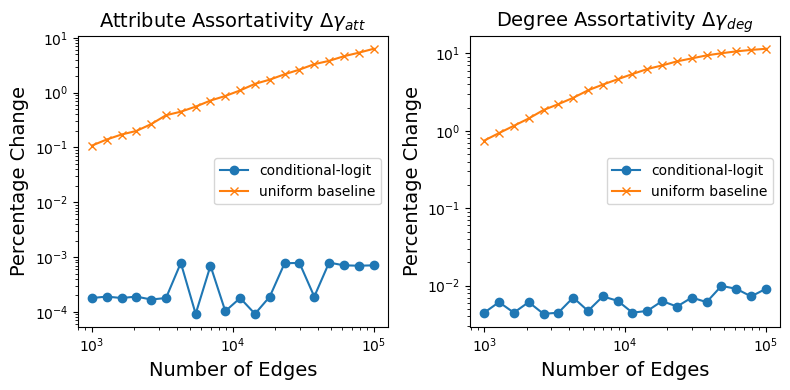

In [66]:
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter
fontsize = 14
markersize = 10
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(results_softmax['num_edges'].values, results_softmax['delta_att'].values, marker='o', label=r"conditional-logit")
ax[0].plot(results_softmax['num_edges'].values, results_uniform['delta_att'].values, marker='x', label=r"uniform baseline")

ax[1].plot(results_softmax['num_edges'].values, results_softmax['delta_deg'].values, marker='o', label=r"conditional-logit")
ax[1].plot(results_softmax['num_edges'].values, results_uniform['delta_deg'].values, marker='x', label=r"uniform baseline")

titles = [r"Attribute Assortativity $\Delta \gamma_{att}$", r"Degree Assortativity $\Delta \gamma_{deg}$"]
for idx, ax_sub in enumerate(ax):
    ax_sub.set_xscale('log')
    ax_sub.set_yscale('log', nonpositive='clip') # 
    ax_sub.legend()
    ax_sub.set_xlabel('Number of Edges', fontsize=fontsize)
    ax_sub.set_ylabel('Percentage Change', fontsize=fontsize)
    ax_sub.set_title(titles[idx], fontsize=fontsize)
#     ax_sub.yaxis.set_major_formatter(mticker.ScalarFormatter()) #style='plain'
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "edge_addition_assortativity_log.png"), dpi=100)

In [ ]:
plt.plot(loss_history)